In [1]:
# !pip uninstall --yes qiskit qiskit-terra

In [2]:
# !pip install qiskit

In [3]:
# !pip install -U qiskit-aer

## Non-noisy model

In [4]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

Measurement Counts: {'01000100': 1, '10101101': 1, '01001001': 1, '01011100': 1, '10110010': 1, '01010011': 2, '00010110': 2, '00110100': 1, '10001011': 1, '00101100': 1, '00001111': 1, '00000011': 1, '10010110': 2, '01010111': 1, '10010011': 1, '01001010': 1, '11110000': 2, '01000101': 2, '00000111': 1, '11010001': 1, '11100110': 2, '10000101': 3, '10110000': 1, '00010111': 2, '01011101': 4, '00110101': 1, '00111001': 3, '00010101': 1, '11101000': 2, '01110110': 3, '01100011': 4, '10111001': 8, '01011010': 1, '10011110': 3, '11000111': 4, '01111000': 1, '00101001': 1, '11001100': 1, '10010101': 2, '11111000': 4, '01110010': 2, '10010000': 1, '10000010': 1, '01110101': 2, '10000110': 1, '01011000': 2, '11010101': 2, '11101010': 4, '00111101': 2, '11110011': 6, '11100011': 4, '10101010': 4, '10000111': 1, '01101101': 5, '11000110': 1, '11001001': 1, '00111011': 5, '00101110': 3, '11100010': 3, '11010011': 5, '00100100': 1, '00011110': 2, '10011001': 1, '10110100': 4, '01001111': 2, '110

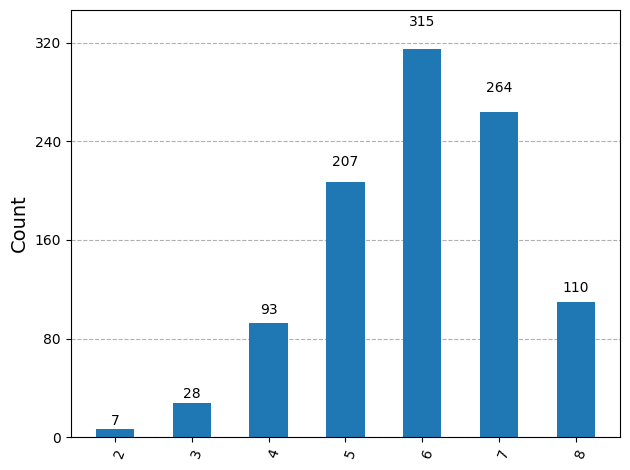

In [5]:
# set number of levels and pegs
n_levels_and_pegs = 8
theta = np.pi / 3 # this should skew our distribution right
# we need the ClassicalRegister for our swap
qr = QuantumRegister(n_levels_and_pegs, 'q')
cr = ClassicalRegister(n_levels_and_pegs, 'c')
qc3 = QuantumCircuit(qr, cr)

# We use the usual hadamard to simulate our pegs, but this time,
# we use a loop to initialize the levels and pegs
# for a simple n-level board, Hadamard gates suffice to generate the binomial distribution.
for i in range(n_levels_and_pegs):
## we use Ry(\theta) instead of Hadamard and this should give us a distribution that skews right.
    qc3.ry(2 * theta, i)

# We take a measurement. 
qc3.measure(qr, cr)

## we measure after to get our distribution
# here we are counting in the bitstring the number of 1s
# this gives us a pretty good count of our distribution ie. binomial
simulator = Aer.get_backend('qasm_simulator')

# Transpile the circuit for the simulator
compiled_circuit = transpile(qc3, simulator)

# Execute the circuit and get the results
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()

# Get the measurement outcomes
counts = result.get_counts(qc3)

print("Measurement Counts:", counts)
bin_counts = {}
for bitstring, count in counts.items():
    num_ones = bitstring.count('1')
    bin_counts[num_ones] = bin_counts.get(num_ones, 0) + count

plot_histogram(bin_counts)

## Noisy model

In [6]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

Measurement Counts: {'1000': 8, '1001': 23, '1010': 25, '1100': 20, '0100': 27, '0101': 65, '1011': 68, '1111': 229, '1101': 71, '1110': 77, '0001': 23, '0011': 82, '0111': 201, '0010': 23, '0000': 12, '0110': 70}


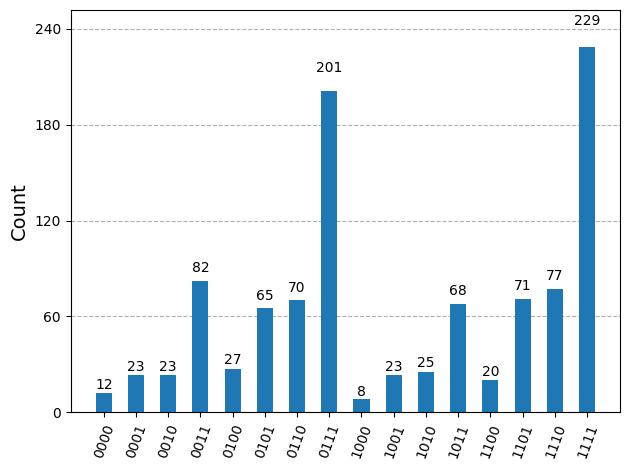

In [7]:
# Number of levels (rows of pegs) in the Galton box
n_levels = 4
num_levels = 8

# Number of qubits required (num_levels for position + 1 for ancilla)
num_qubits = 8

# Here we would create a quantum circuit with say, 3 qubits and 2 classical bits
# Instead, now, we have n_levels for the ball to traverse and we use 
# n_levels classical bits for measurements
qr = QuantumRegister(n_levels, 'q')
cr = ClassicalRegister(n_levels, 'c')
qc4 = QuantumCircuit(qr, cr)
## This should skew our distribution right
theta = np.pi / 3
# Initialize the first qubit (representing the ball's initial position) to a superposition
# Using a Hadamard gate on the first qubit simulates the 50/50 chance of going left or right
qc4.h(qr[0])


# We now put this in a for loop for multiple pegs at each level
for i in range(1, n_levels):
    # Simulate a peg: Hadamard for random left/right choice
    qc4.ry(2 * theta, i)
    
    # we use the SWAP here. Instead of a single swap i.e. qc1.cswap(0, 1, 2)
    # since we now have a for loop, we swap the previous level's choice
    # i.e. qr[i-1] to decide whether the current level qr[i] should swap
    # for the rhs bin
    # we then do a measure
    qc4.swap(qr[i-1], qr[i])

    # then we do a RESET. We need to measure before resetting or the histogram
    # only measures the last result i.e. 1 value
    qc4.measure(qr[i-1], cr[i-1])
    qc4.reset(qr[i-1])

qc4.measure(qr[n_levels -1], cr[n_levels - 1])

simulator = Aer.get_backend('qasm_simulator')

# Transpile the circuit for the simulator
compiled_circuit = transpile(qc4, simulator)

# Execute the circuit and get the results
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()

# Get the measurement outcomes
counts = result.get_counts(qc4)
print("Measurement Counts:", counts)

# Plot the results as a histogram
plot_histogram(counts)